# Анализ продаж компьютерных игр

### Структура проекта:   
- Откроем файл с данными и изучим общую информацию
- Исследовательский анализ данных
    - Сколько игр выпускалось в разные годы
    - Как менялись продажи по платформам
    - Актуальный период
    - Актуальные платформы
    - Зависимость продаж от оценок пользователей
    - Зависимость цены от жанра
- Портрет пользователя для каждого региона
    - Платформы
    - Жанры
- Проверяем гипотезы
    - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
    - Средние пользовательские рейтинги жанров Action и Sports разные
- Общий вывод

### Описание данных:

- *Name* — название игры
- *Platform* — платформа
- *Year_of_Release* — год выпуска
- *Genre* — жанр игры
- *NA_sales —* продажи в Северной Америке (миллионы долларов)
- *EU_sales* — продажи в Европе (миллионы долларов)
- *JP_sales* — продажи в Японии (миллионы долларов)
- *Other_sales —* продажи в других странах (миллионы долларов)
- *Critic_Score* — оценка критиков (от 0 до 100)
- *User_Score* — оценка пользователей (от 0 до 10)
- *Rating* — рейтинг от организации *ESRB* (англ. *Entertainment Software Rating Board).* Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np
from scipy import stats as st
from io import BytesIO
import requests

In [2]:
pd.options.display.max_columns = 30

df = pd.read_csv('C:\\Users\\admin\\Documents\\Project Python\\5. Изучение закономерностей, которые влияют на успешность игр\\games.csv')
display(df.head())
df.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [35]:
print('Пропущеные значения, от общего числа значений в столбце')
pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm')

Пропущеные значения, от общего числа значений в столбце


,0
name,0.000000
platform,0.000000
year_of_release,0.000000
genre,0.000000
na_sales_mil_dol,0.000000
eu_sales_mil_dol,0.000000
jp_sales_mil_dol,0.000000
other_sales,0.000000
critic_score,51.340000
user_score,54.480000


## Предобработка данных

In [5]:
# Сделаем названия столбцов строчными
df.columns = df.columns.str.lower()
# Поменям названия столбцов NA_sales, EU_sales, JP_sales, чтобы было понятно что обозначают цифры
df = df.rename(columns={'na_sales':'na_sales_mil_dol', 'eu_sales':'eu_sales_mil_dol','jp_sales':'jp_sales_mil_dol'}) 
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales_mil_dol',
       'eu_sales_mil_dol', 'jp_sales_mil_dol', 'other_sales', 'critic_score',
       'user_score', 'rating'],
      dtype='object')

In [6]:
# Посмотрим на значения столбца genre
df['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

In [7]:
# Удалим пропуски в столбце name
df = df[~df['name'].isna()]

# Датафрейм-словарь с датой выхода игр (взят c Wikipedia)
spreadsheet_id = '1HHqpej7eXOjbabhSH38gryDKYDF5lq4SNi4Dd5-rjro'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
year_of_release = pd.read_csv(BytesIO(r.content))

print('Количество пропусков в столбце year_of_release:', df['year_of_release'].isna().sum())

# Создадим столбец для совпадающих значений
df = df.merge(year_of_release, how='left', on='name')

# Заменим пропуски найдеными значениями
df['year_of_release'] = df['year_of_release'].fillna(df['year'])

# Удалим ненужный столбец
df = df.drop(columns='year')
print('Количество пропусков в столбце year_of_release после обработки:', df['year_of_release'].isna().sum(),
     '-- {:.1%} от общего количества строк'.format(df['year_of_release'].isna().sum()/len(df['year_of_release'])))

# Остальные пропуски составляют малый процент от общего числа значений их можно удалить.
df = df[~df['year_of_release'].isna()]
df['year_of_release'] = df['year_of_release'].astype(int)
df.sample()

Количество пропусков в столбце year_of_release: 269
Количество пропусков в столбце year_of_release после обработки: 226 -- 1.3% от общего количества строк


,name,platform,year_of_release,genre,na_sales_mil_dol,eu_sales_mil_dol,jp_sales_mil_dol,other_sales,critic_score,user_score,rating
1577,Battlefield: Bad Company,X360,2008,Shooter,0.81,0.46,0.04,0.15,83.0,7.7,T


In [8]:
# Посмотрим на пропуски в столбце rating
df[df['rating'].isna()].sample()

,name,platform,year_of_release,genre,na_sales_mil_dol,eu_sales_mil_dol,jp_sales_mil_dol,other_sales,critic_score,user_score,rating
10152,Sid Meier's Pirates!,XB,2005,Strategy,0.11,0.03,0.0,0.01,NaN,NaN,NaN


В большинстве случаев пропуски в столбцах critic_score, user_score, rating совпадают. Пропусков рейтинга слишком много, что бы мы могли их восстановить или удалить. Установим значение-заглушку, но для начала посмотрим, какие значения рейтинга у нас вообще есть:

In [9]:
df['rating'] = df['rating'].fillna('Unknown')
df['rating'].value_counts()

Unknown    6822
E          4245
T          3283
M          1818
E10+       1536
EC            8
K-A           3
AO            3
RP            1
Name: rating, dtype: int64

4 вида рейтинга встречаются часто: Е, Т, М и Е10+. А остальные почти не встречаются. Их можно заменить:

- АО - на М;
- RP - фактически, рейтинг не известен. Можно заменить на Unknown;
- ЕС - на Е;
- К-А - на Е.

In [10]:
# Посмоттрим какие значения встречаются в столбцах critic_score и user_score
print(df['critic_score'].unique())
df['user_score'].unique()

[76. nan 82. 80. 89. 58. 87. 91. 61. 97. 95. 77. 88. 83. 94. 93. 85. 86.
 98. 96. 90. 84. 73. 74. 78. 92. 71. 72. 68. 62. 49. 67. 81. 66. 56. 79.
 70. 59. 64. 75. 60. 63. 69. 50. 25. 42. 44. 55. 48. 57. 29. 47. 65. 54.
 20. 53. 37. 38. 33. 52. 30. 32. 43. 45. 51. 40. 46. 39. 34. 35. 41. 36.
 28. 31. 27. 26. 19. 23. 24. 21. 17. 13.]


array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Значения представлены в числовом формате менять пропуски на заглушки не оптимально с учетом дальнейшего исследования. Приведем рейтинг пользователей и критиков в единый фомат для большего удобства. tbd - to be determined (рейтинг не определен) заменим пустыми значениями и поменяем формат на числовой.

In [11]:
df['user_score'] = df['user_score'].replace('tbd', np.NaN).astype(float)   
df['critic_score'] = df['critic_score'] / 10
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17719 entries, 0 to 17944
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              17719 non-null  object 
 1   platform          17719 non-null  object 
 2   year_of_release   17719 non-null  int32  
 3   genre             17719 non-null  object 
 4   na_sales_mil_dol  17719 non-null  float64
 5   eu_sales_mil_dol  17719 non-null  float64
 6   jp_sales_mil_dol  17719 non-null  float64
 7   other_sales       17719 non-null  float64
 8   critic_score      9067 non-null   float64
 9   user_score        8555 non-null   float64
 10  rating            17719 non-null  object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.6+ MB


In [12]:
# Пропуски обработаны. Добавим столбец с сумарными продажами по все регионам
df['total_sales_mil_dol'] = df[['na_sales_mil_dol', 'eu_sales_mil_dol', 'jp_sales_mil_dol', 'other_sales']].sum(axis=1)
df.sample()

,name,platform,year_of_release,genre,na_sales_mil_dol,eu_sales_mil_dol,jp_sales_mil_dol,other_sales,critic_score,user_score,rating,total_sales_mil_dol
13455,F1 2001,XB,2001,Racing,0.05,0.01,0.0,0.0,8.3,5.5,E,0.06


Проверим дубликаты. Единственно возможный вариант неявных дублей - это игры с одинаковыми названиями, но с разными жанрами. 

In [13]:
df.duplicated()
df = df.drop_duplicates()
# Проверим неявные дубликаты: название игры - жанр игры
display(df[df['name'].duplicated() & ~df['genre'].duplicated()])
# Проверим неявные дубликаты: наименование платформы - название игры - год выпуска
display(df[df[['name', 'platform', 'year_of_release']].duplicated()])
# Посмотрим на каждое значение
display(df[df['name'] == 'Sonic the Hedgehog'])
display(df[df['name'] == 'Madden NFL 13'])
# Удалим строки в которых меньше информации
df.drop(labels = [17447, 4736], axis = 0, inplace = True)
# И проверим результат
display(df[df[['name', 'platform', 'year_of_release']].duplicated()])

,name,platform,year_of_release,genre,na_sales_mil_dol,eu_sales_mil_dol,jp_sales_mil_dol,other_sales,critic_score,user_score,rating,total_sales_mil_dol


,name,platform,year_of_release,genre,na_sales_mil_dol,eu_sales_mil_dol,jp_sales_mil_dol,other_sales,critic_score,user_score,rating,total_sales_mil_dol
4736,Sonic the Hedgehog,PS3,2006,Platform,0.0,0.48,0.0,0.0,4.3,4.1,E10+,0.48
17447,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.0,0.0,8.3,5.5,E,0.01


,name,platform,year_of_release,genre,na_sales_mil_dol,eu_sales_mil_dol,jp_sales_mil_dol,other_sales,critic_score,user_score,rating,total_sales_mil_dol
315,Sonic the Hedgehog,GEN,1991,Platform,3.03,0.91,0.26,0.13,NaN,NaN,Unknown,4.33
2066,Sonic the Hedgehog,PS3,2006,Platform,0.41,0.06,0.04,0.66,4.3,4.1,E10+,1.17
2342,Sonic the Hedgehog,X360,2006,Platform,0.44,0.48,0.00,0.11,4.6,4.4,E10+,1.03
4736,Sonic the Hedgehog,PS3,2006,Platform,0.00,0.48,0.00,0.00,4.3,4.1,E10+,0.48


,name,platform,year_of_release,genre,na_sales_mil_dol,eu_sales_mil_dol,jp_sales_mil_dol,other_sales,critic_score,user_score,rating,total_sales_mil_dol
615,Madden NFL 13,X360,2012,Sports,2.53,0.15,0.0,0.17,8.1,5.8,E,2.85
746,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,8.3,5.5,E,2.56
4585,Madden NFL 13,Wii,2012,Sports,0.47,0.00,0.0,0.03,NaN,7.3,E,0.50
6652,Madden NFL 13,PSV,2012,Sports,0.28,0.00,0.0,0.02,6.3,7.3,E,0.30
7902,Madden NFL 13,WiiU,2012,Sports,0.21,0.00,0.0,0.02,7.5,6.7,E,0.23
17447,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,8.3,5.5,E,0.01


,name,platform,year_of_release,genre,na_sales_mil_dol,eu_sales_mil_dol,jp_sales_mil_dol,other_sales,critic_score,user_score,rating,total_sales_mil_dol


## Исследовательский анализ данных
### Сколько игр выпускалось в разные годы

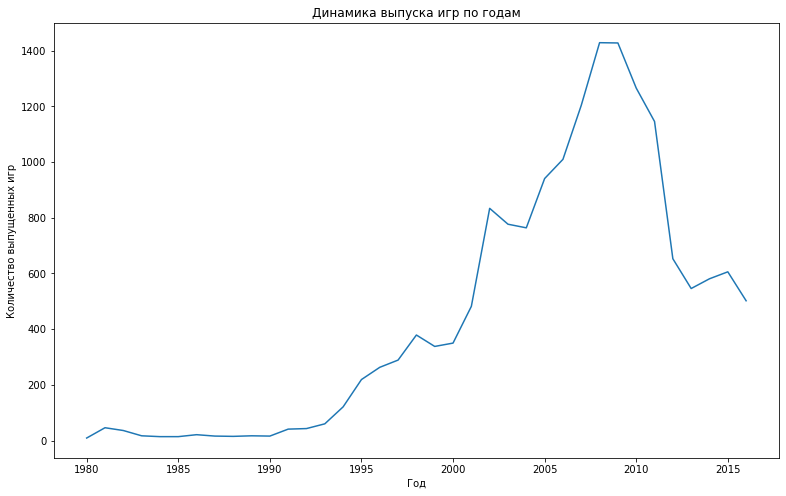

In [14]:
year_games = df.pivot_table(index='year_of_release', values='name', aggfunc='count')

plt.figure(figsize=(13, 8))
(sns.lineplot(data = year_games, x = year_games.index, y = 'name')
    .set(title = 'Динамика выпуска игр по годам', xlabel = 'Год', ylabel = 'Количество выпущенных игр'))
plt.show()

**Вывод:** Мы видим, что до 2000 игр выпускалось крайне мало, вероятно индустрия только зарождалась. Скачок произошел с 2001-2002 и длился до пика 2008-2009 года, после чего количество выпускаемых игр пошло на спад, полагаю это может быть связано с разивтием мобильной индустрии, увеличением времени и средств на разработку игр

### Как менялись продажи по платформам

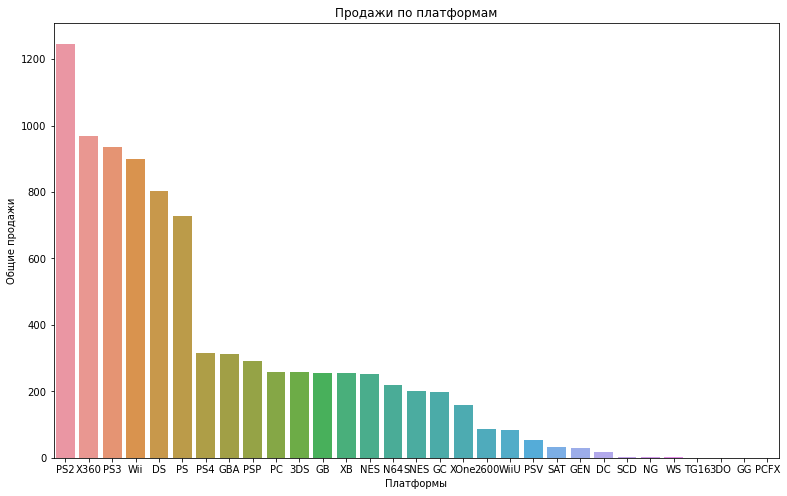

In [15]:
# Делаем группировку по общей сумме продаж
platform_sales = (df.pivot_table(index='platform', values='total_sales_mil_dol', aggfunc='sum')
                    .sort_values('total_sales_mil_dol', ascending=False))
# Строим гистограмму
plt.figure(figsize=(13, 8))
(sns.barplot(data = platform_sales, x = platform_sales.index, y = 'total_sales_mil_dol')
    .set(title = 'Продажи по платформам', xlabel = 'Платформы', ylabel = 'Общие продажи'))
plt.show()

Лидирующие позиции занимают 6 платформ:
- PS2
- X360
- PS3
- Wii
- DS
- PS

Посмотрим как менялись продажи по годам для каждой из них.

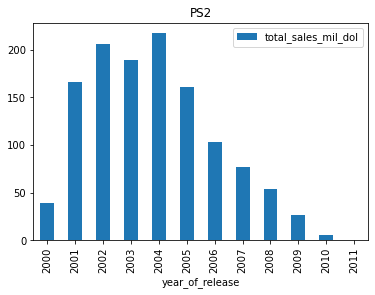

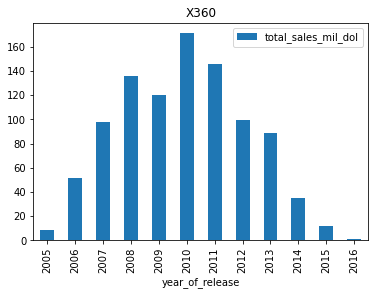

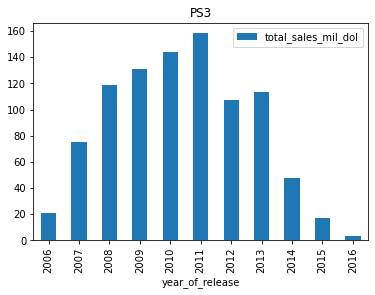

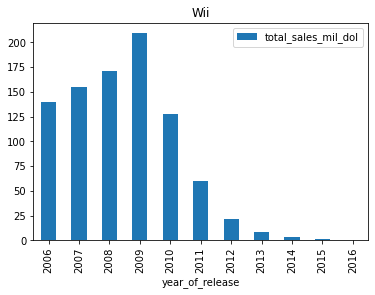

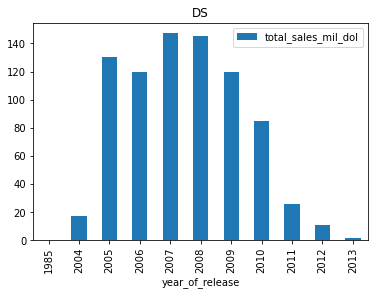

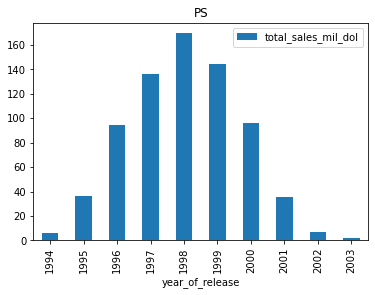

In [16]:
for platform in platform_sales.index[:6]:
    (df[df['platform'] == platform]
       .pivot_table(index='year_of_release', values='total_sales_mil_dol', aggfunc='sum')
       .plot(kind='bar', title=platform))
    plt.show()

Промежуточные выводы:
- PS2: стадия роста - 1 год, стадия активных продаж - 4 года, стадия спада - 5 лет
- X360: стадия роста - 2 года, стадия активных продаж - 6 лет, стадия спада - 2 года
- PS3: стадия роста - 2 года, стадия активных продаж - 5 лет, стадия спада - 3 года
- Wii: стадия роста - 1 год, стадия активных продаж - 4 года, стадия спада - 3 года
- DS: стадия роста - 1 года, стадия активных продаж - 5 лет, стадия спада - 2 года
- PS: стадия роста - 2 года, стадия активных продаж - 4 года, стадия спада - 2 года

Общий вывод:
- Cредняя стадия роста - 1.5 года 
- Средняя активных продаж - 4.6 лет 
- Средняя стадия спада - 2.8 лет

***Актуальным периодом для исследования можно считать 3 года, за него можно увидеть на какой стадии находится платформа.***

### Актуальный период

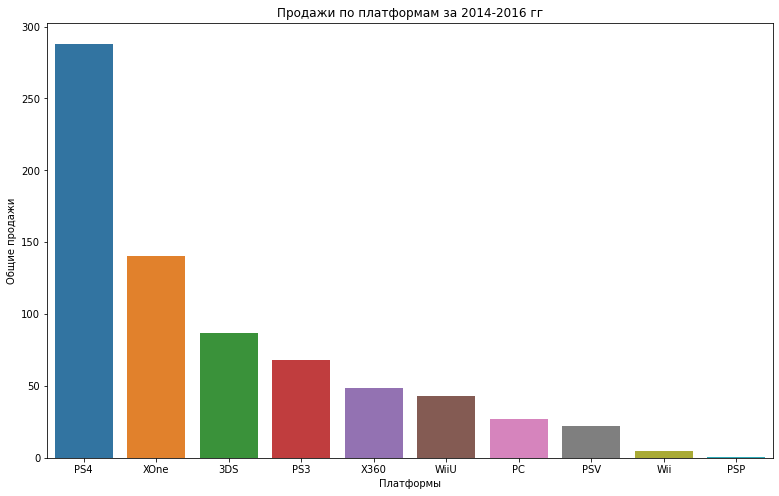

In [17]:
# Обрезаем датафрейм
df_fresh = df.query('year_of_release >= 2014')
# Делаем группировку по общей сумме продаж
platform_sales_fresh = (df_fresh.pivot_table(index='platform', values='total_sales_mil_dol', aggfunc='sum')
                                .sort_values('total_sales_mil_dol', ascending=False))
# Строим гистограмму
plt.figure(figsize=(13, 8))
(sns.barplot(data = platform_sales_fresh, x = platform_sales_fresh.index, y = 'total_sales_mil_dol')
    .set(title = 'Продажи по платформам за 2014-2016 гг', xlabel = 'Платформы', ylabel = 'Общие продажи'))
plt.show()

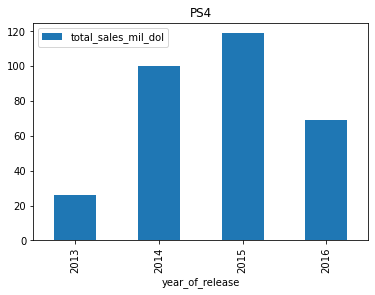

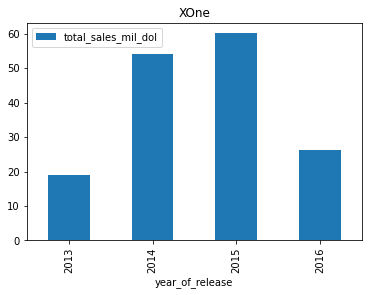

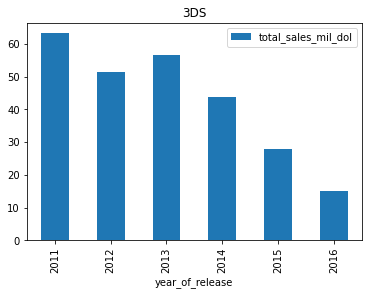

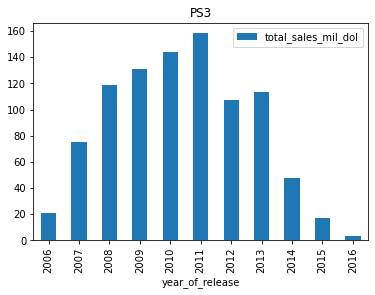

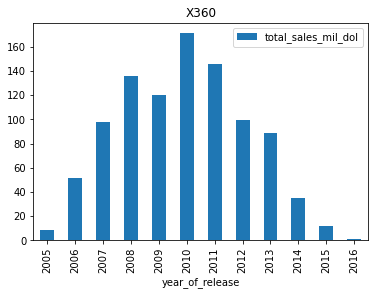

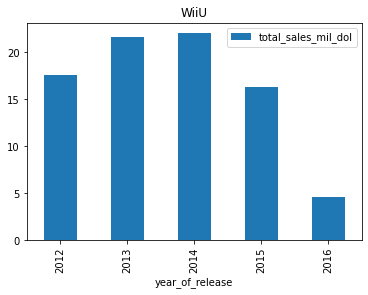

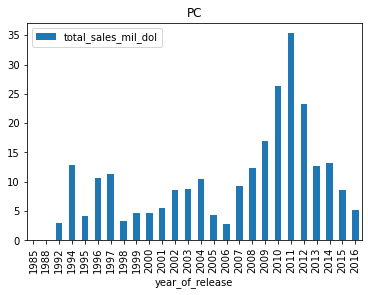

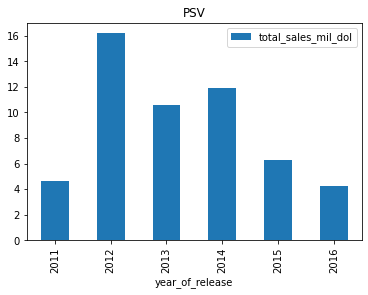

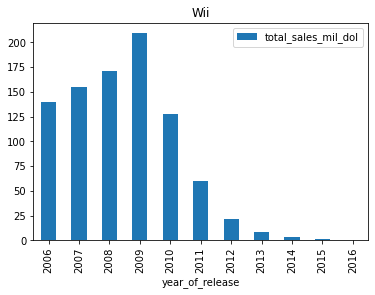

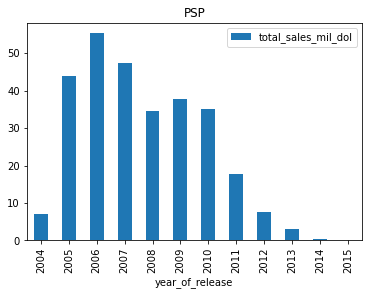

In [18]:
# Посмотрим на распределение по годам для каждой из них.
for platform in platform_sales_fresh.index:
    (df[df['platform'] == platform]
       .pivot_table(index='year_of_release', values='total_sales_mil_dol', aggfunc='sum')
       .plot(kind='bar', title=platform))
    plt.show()

Платформы которые находятся в стадии роста или активных продаж (являются потенциально прибыльными):
- PS4
- XOne


Платформы которые теряют свою актуальность:
- 3DS
- WiiU
- PSV

Платформы которые полностью потеряли актуальность:
- Wii
- PSP
- X360
- PS3


Отдельно хочу выделить PC, как платформу, которая имеет несколько пиков продаж и хотя сейчас находится на спаде, возможен новый актуальный пик. Спады продаж этой платформы можно связать с периодами роста других платформ, так например на период сильного спада продаж 2006 года, было несколько крупных платформ - конкурентов: Wii, PS2, X360.

### Актуальные платформы

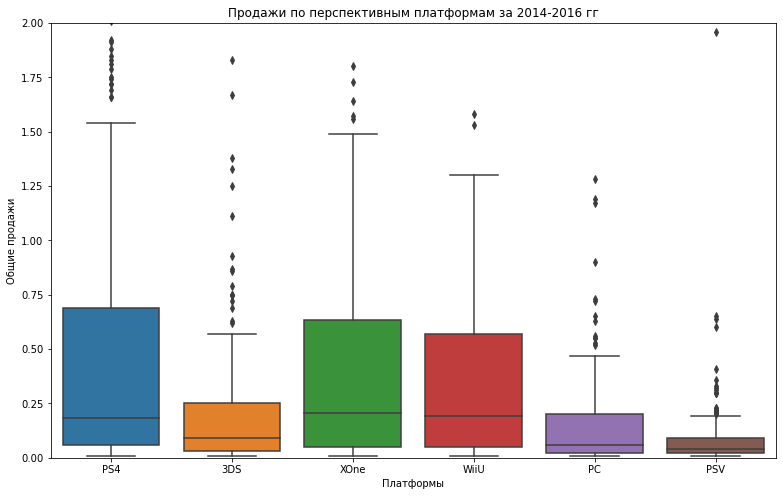

ТАБЛИЦА ХАРАКТЕРНЫХ ЗНАЧЕНИЙ ДЛЯ ПЕРПЕКТИВНЫХ ПЛАТФОРМ


,25%,50%,75%,count,max,mean,min,std
platform,,,,,,,,
3DS,0.0300,0.090,0.2500,212.0,11.68,0.408868,0.01,1.188368
PC,0.0200,0.060,0.2000,151.0,3.05,0.179139,0.01,0.329359
PS4,0.0575,0.185,0.6900,376.0,14.63,0.766356,0.01,1.614969
PSV,0.0200,0.040,0.0900,295.0,1.96,0.075932,0.01,0.141591
WiiU,0.0500,0.190,0.5700,73.0,7.09,0.588767,0.01,1.161467
XOne,0.0500,0.205,0.6325,228.0,7.39,0.615614,0.01,1.046513


In [19]:
# Уберем платформы, которые потеряли актуальность
df_fresh = df_fresh.query('(platform == "PS4") or (platform == "XOne") or (platform == "WiiU") or (platform == "PSV") or (platform == "3DS") or (platform == "PC")')
# Строим диаграмму ящик с усами 
plt.figure(figsize=(13, 8))
(sns.boxplot(data = df_fresh, y = 'total_sales_mil_dol', x='platform')
    .set(title = 'Продажи по перспективным платформам за 2014-2016 гг', 
         xlabel = 'Платформы', 
         ylabel = 'Общие продажи', 
         ylim=(0, 2))) # Ставим ограничение, чтобы график был более наглядным, можно убрать, чтобы увидеть выбросы
plt.show()

print('ТАБЛИЦА ХАРАКТЕРНЫХ ЗНАЧЕНИЙ ДЛЯ ПЕРПЕКТИВНЫХ ПЛАТФОРМ')
df_fresh.pivot_table(index='platform', values='total_sales_mil_dol', aggfunc='describe')

- Лидерами по продажам являются PS4, XOne и WiiU однако не забываем, что эта платфорама находит на стадии спада.
- Платформа 3DS  имеет средние показатели и также находится на стадии спада.
- PSV является наимеене предпочтительной платформой, хотя для нее выпускается большое количество игр (2 место после PS4), это может быть от части связано с меньшей ценой за игры, относительно других консолей.
- Платформа PC имеет низкие показатели, но ее прибыльность зависит во многом от того на какой стадии находятся другие актуальные платформы.


Все платформы имеют выбросы, они могу быть связаны с играми-эксклюзивами для конкретных платформ и играми которые "выстрелили". В какой-то степени выбросы также характеризуют платформы, так как эксклюзивы для платформ будут выходить постоянно, но сверх прибыльные проекты сильно искажают данные, поэтому лучше обрезать датафрейм ограничившись проектами до 4 миллионов.

In [20]:
df_fresh_b4 = df_fresh[df_fresh['total_sales_mil_dol'] <= 4]

print('ТАБЛИЦА ХАРАКТЕРНЫХ ЗНАЧЕНИЙ ДЛЯ ПЕРПЕКТИВНЫХ ПЛАТФОРМ ПОСЛЕ ОБРЕЗКИ')
df_fresh_b4.pivot_table(index='platform', values='total_sales_mil_dol', aggfunc='describe')

ТАБЛИЦА ХАРАКТЕРНЫХ ЗНАЧЕНИЙ ДЛЯ ПЕРПЕКТИВНЫХ ПЛАТФОРМ ПОСЛЕ ОБРЕЗКИ


,25%,50%,75%,count,max,mean,min,std
platform,,,,,,,,
3DS,0.03,0.08,0.2400,209.0,3.89,0.288565,0.01,0.586757
PC,0.02,0.06,0.2000,151.0,3.05,0.179139,0.01,0.329359
PS4,0.05,0.17,0.6000,359.0,3.97,0.486100,0.01,0.758963
PSV,0.02,0.04,0.0900,295.0,1.96,0.075932,0.01,0.141591
WiiU,0.05,0.17,0.5175,70.0,3.21,0.379714,0.01,0.519785
XOne,0.05,0.18,0.5950,223.0,3.66,0.509103,0.01,0.756497


### Зависимость продаж от оценок пользователей и критиков.

Возьмем несколько популярных, в разные периоды времени платформ, чтобы посмотреть зависимоть дохода от оценки критиков или пользователей

In [21]:
# Пишем функцию для диграммы зависимости цены от оценки критиков и пользователей.
def score_sales_diag(name):
    platform = df.query('platform == @name')
    print(f'ПЛАТФОРМА {name}')
    plt.figure(figsize=(14,6))
    platform.plot(kind='scatter', x='critic_score', y='total_sales_mil_dol', 
                  ax=plt.subplot(1,2,1), xlabel = 'Прибыль', ylabel = 'Оценки критиков', alpha=0.4)
    platform.plot(kind='scatter', x='user_score', y='total_sales_mil_dol', 
                  ax=plt.subplot(1,2,2), xlabel = 'Прибыль', ylabel = 'Оценки пользователей', alpha=0.4)
    plt.show()
    print('КОЭФФИЦИЕНТЫ КОРРЕЛЯЦИИ')
    print(platform[['critic_score', 'user_score', 'total_sales_mil_dol']].corr()['total_sales_mil_dol'])

ПЛАТФОРМА PS4


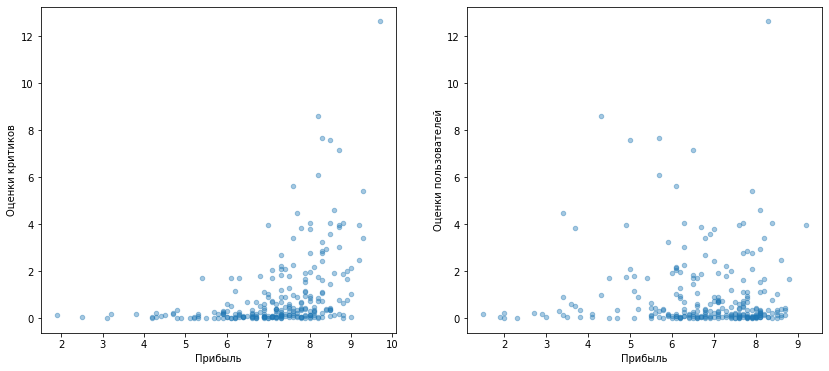

КОЭФФИЦИЕНТЫ КОРРЕЛЯЦИИ
critic_score           0.406568
user_score            -0.031957
total_sales_mil_dol    1.000000
Name: total_sales_mil_dol, dtype: float64


In [22]:
score_sales_diag('PS4')

ПЛАТФОРМА PS3


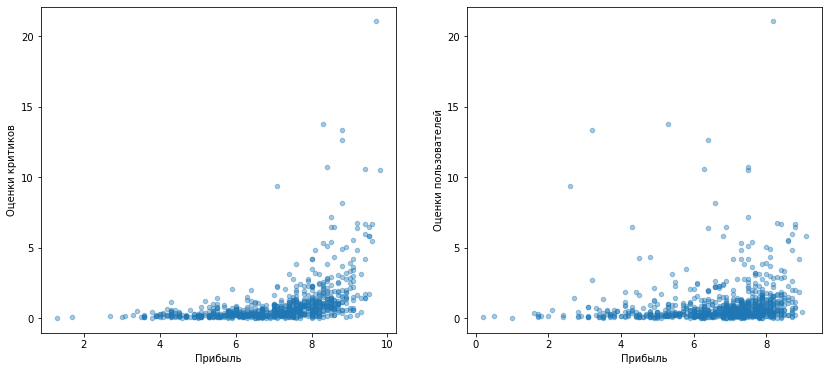

КОЭФФИЦИЕНТЫ КОРРЕЛЯЦИИ
critic_score           0.433497
user_score             0.127565
total_sales_mil_dol    1.000000
Name: total_sales_mil_dol, dtype: float64


In [23]:
score_sales_diag('PS3')

ПЛАТФОРМА PS2


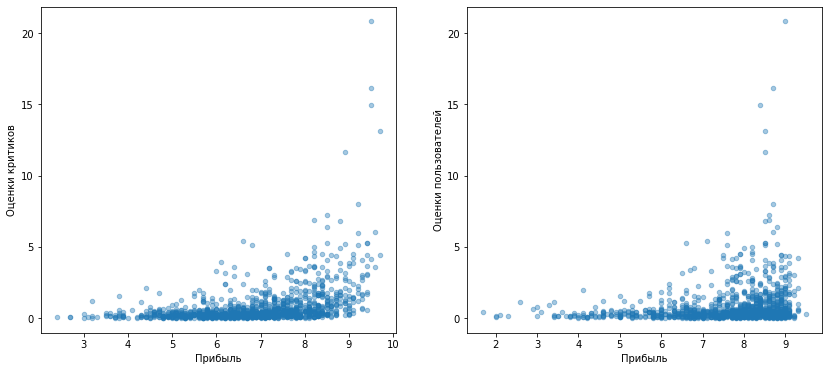

КОЭФФИЦИЕНТЫ КОРРЕЛЯЦИИ
critic_score           0.395648
user_score             0.177384
total_sales_mil_dol    1.000000
Name: total_sales_mil_dol, dtype: float64


In [24]:
score_sales_diag('PS2')

ПЛАТФОРМА PS


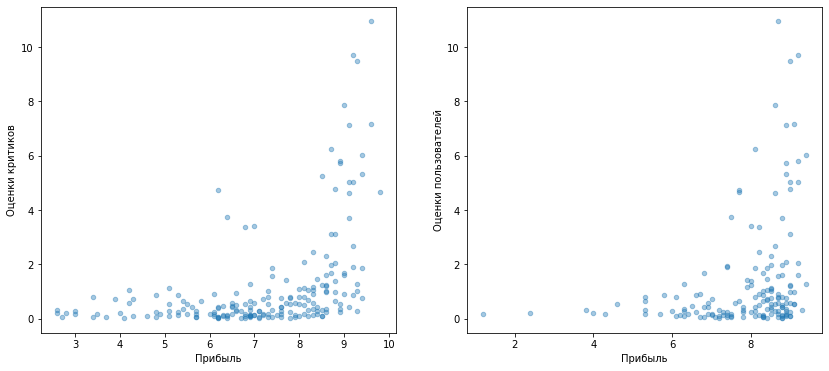

КОЭФФИЦИЕНТЫ КОРРЕЛЯЦИИ
critic_score           0.446690
user_score             0.300078
total_sales_mil_dol    1.000000
Name: total_sales_mil_dol, dtype: float64


In [25]:
score_sales_diag('PS')

ПЛАТФОРМА X360


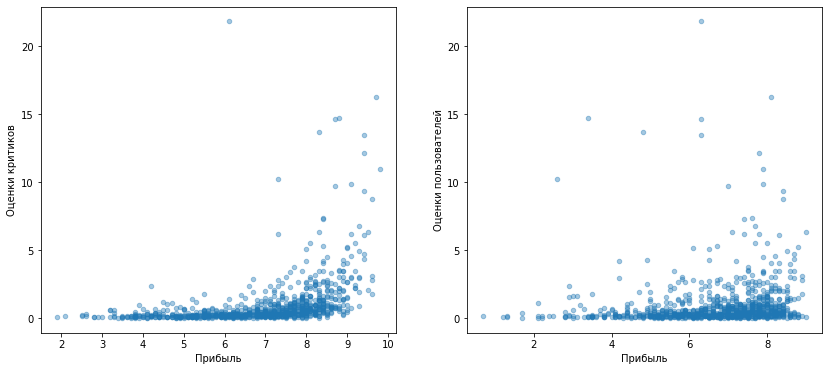

КОЭФФИЦИЕНТЫ КОРРЕЛЯЦИИ
critic_score           0.393122
user_score             0.116096
total_sales_mil_dol    1.000000
Name: total_sales_mil_dol, dtype: float64


In [26]:
score_sales_diag('X360')

ПЛАТФОРМА XOne


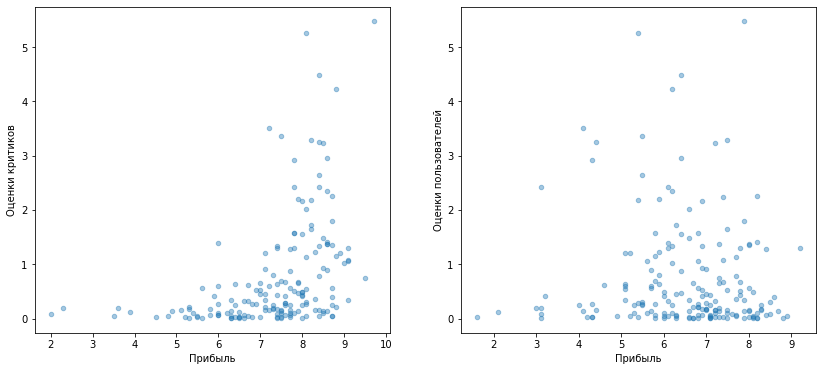

КОЭФФИЦИЕНТЫ КОРРЕЛЯЦИИ
critic_score           0.416998
user_score            -0.068925
total_sales_mil_dol    1.000000
Name: total_sales_mil_dol, dtype: float64


In [27]:
score_sales_diag('XOne')

**Вывод:** В результате анализа мы видим, что коэффициенты корреляций относительно невысокие, однако все же по критикам корреляция куда выше, нежели по пользователям.


### Зависимость цены от жанра

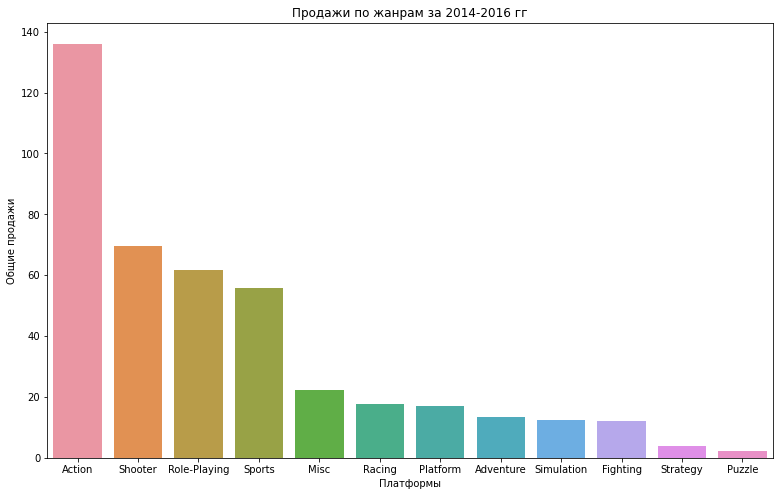

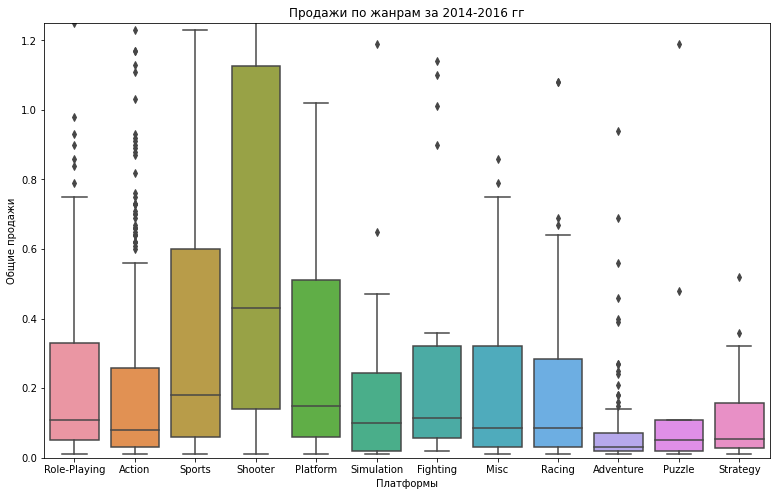

ТАБЛИЦА ХАРАКТЕРНЫХ ЗНАЧЕНИЙ ДЛЯ ЖАНРОВ ИГР


,count,std,median,mean
genre,,,,
Shooter,87,0.945495,0.430,0.800575
Sports,101,0.815456,0.180,0.551485
Platform,33,0.762131,0.150,0.519394
Racing,52,0.573679,0.085,0.342115
Fighting,36,0.551836,0.115,0.340278
Role-Playing,183,0.607337,0.110,0.337923
Simulation,40,0.676415,0.100,0.308250
Action,490,0.551136,0.080,0.277673
Misc,88,0.422760,0.085,0.251250


In [28]:
# Группируем по жанру
genre_sales_fresh = (df_fresh_b4.pivot_table(index='genre', values='total_sales_mil_dol', aggfunc='sum')
                             .sort_values('total_sales_mil_dol', ascending=False))
# Строим гистограмму
plt.figure(figsize=(13, 8))
(sns.barplot(data = genre_sales_fresh, x = genre_sales_fresh.index, y = 'total_sales_mil_dol')
    .set(title = 'Продажи по жанрам за 2014-2016 гг', xlabel = 'Платформы', ylabel = 'Общие продажи'))
plt.show()
# Строим диаграмму ящик с усами
plt.figure(figsize=(13, 8))
(sns.boxplot(data = df_fresh_b4, y = 'total_sales_mil_dol', x='genre')
    .set(title = 'Продажи по жанрам за 2014-2016 гг', 
         xlabel = 'Платформы', 
         ylabel = 'Общие продажи',
         ylim=(0, 1.25)))
plt.show()

print('ТАБЛИЦА ХАРАКТЕРНЫХ ЗНАЧЕНИЙ ДЛЯ ЖАНРОВ ИГР')
# Строк много,  чтобы было легче ориентироваться вместо corr используем отдельные функции
tab_corr = df_fresh_b4.pivot_table(index='genre', values='total_sales_mil_dol', aggfunc=['count', 'std', 'median', 'mean'])   
tab_corr.columns = ['count', 'std', 'median', 'mean']
tab_corr.sort_values('mean', ascending=False)

Выбросы могут быть связаны с играми "выстрелившими в своем жанре".


**Разделим жанры на 3 сегмента прибыльности:**
1. Высокий:
   - Shooter -- Бесспорный лидер, лучше соотношение прибыльности и на втором месте по количеству общих продаж.	
   - Sports -- Хорошие показатели прибыльности, меньшее стандартное отклонение в сравнении с Шутерами, но меньшее число продаж.
   - Role-Playing -- Игр этого жанра выходит в 2 раза больше, чем первых двух, еще меньше стандартное отклонение, но прибыль и общие продажи ниже.
   
2. Средний: 
   - Platform, Racing, Fighting, Simulation -- Имеют примерно одинаковые показатели, отличаются низким количествоим игр в целом.
   - Misc - имеет схожие показатели с другими представителями этого сегмента, однако прибыльность значительно ниже, больший доход достигается большим количеством выпущенных игр 80 против 40 у вышеперечисленных.
   - Action - Лидер по количеству продаж, в основном за счет количества выпущенных игр, большое количество выбросов говорит о том, что жанр в большей степени зависит от того, на сколько популярным получится отдельно взятый проект.

3. Низкий
   - Puzzle, Strategy - самые низкие показатели прибыльности и продаж.
   - Adventure - имеет также низкие показатели, больший доход достигается большим количеством игр (148 против 20 у вышеперечисленных).
   
***Большое количество игр для отдельного жанра, даже при отсутствии большей прибыльности, может говорить о том, что такие игры возможно легче в производстве и требуют меньше затрат.***

## Портрет пользователя каждого региона
### Платформы

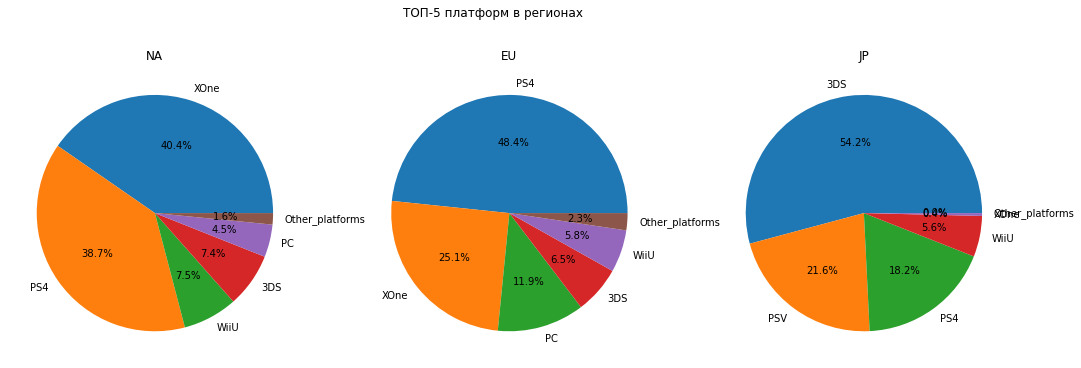

In [29]:
# Задаем список регионов
countries = df_fresh_b4.columns[4:7]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('ТОП-5 платформ в регионах')
for i in range(3):
  # 5 самых продающих платформ
    df_i = (df_fresh_b4.groupby('platform')[countries[i]].sum().reset_index()
                       .sort_values(countries[i], ascending = False, ignore_index = True).head(5))
  # Занесем все остальные продажи в Other_platforms
    df_i = df_i.append({'platform': 'Other_platforms', 
                       countries[i]: abs(df_fresh_b4[countries[i]].sum() - df_i[countries[i]].sum())}, 
                       ignore_index= True)
  # Строим круговую диаграму      
    axs[i].pie(df_i[countries[i]], labels = df_i['platform'], autopct='%.1f%%')
  # Зададим название региона.
    axs[i].set_title(df_i.columns[1].split('_')[0].upper())
plt.show()

Северная америка:
- лидирующие позиции занимают PS4 и XOne и при примерно одинаковых долях занимают 80% рынка.
- значительно меньшие, равнозначные доли у консолей WiiU и 3DS (по 6.9%)
- и наименьшую долю занимает PC (4.1%)

Европа:
- лидирует PS4 (52%), и также довольно бальшая доля XOne (23.6%)
- меньшую долю занимает PC (10.8%)
- и малыми долями представлены консоли WiiU и 3DS (менее 6%)

Япония:
- лидирует 3DS (53.5%)
- 40% рынка распределились примерно равными долями между консолями PS4 и PSV
- и малую часть занимает WiiU (5.5%)

**Общий вывод:**
Для Северной америки и Европы картина схожая - лидерамим является PS4 и XOne, остальные консоли обладают значительно меньшими долями, в Японии предпочитают консоли местного производства, лидерами являются 3DS и коносоли от Sony.

### Жанры

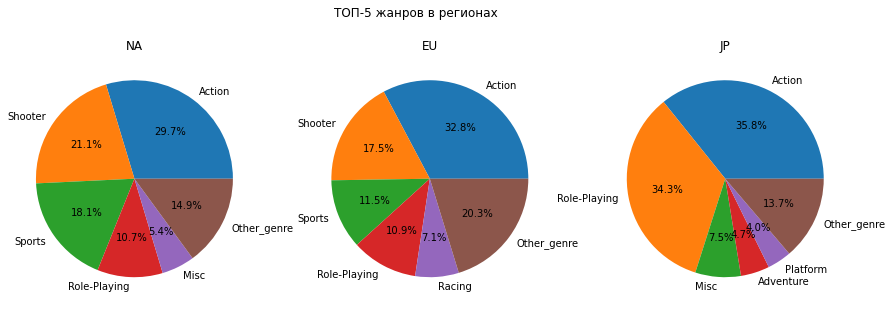

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('ТОП-5 жанров в регионах')
for i in range(3):
  # 5 самых продающих жанров
    df_i = (df_fresh_b4.groupby('genre')[countries[i]].sum().reset_index()
                       .sort_values(countries[i], ascending = False, ignore_index = True).head(5))
    
  # Занесем все остальыне жанры в Other_genre
    df_i = df_i.append({'genre': 'Other_genre', 
                       countries[i]: df_fresh_b4[countries[i]].sum() - df_i[countries[i]].sum()}, 
                       ignore_index= True)
  # Строим круговую диаграму  
    axs[i].pie(df_i[countries[i]], labels = df_i['genre'], autopct='%.1f%%')
    axs[i].set_title(df_i.columns[1].split('_')[0].upper())
plt.show()

- Игры жанра Action лидируют занимая более 30% рынка для каждого региона.
- По остальным жанрам в Европе и Северной америке схожая ситуация - выделяются: Shooter, Sports, Role-Plaing с небольшими отличиями.
- В японии жанр Role-Plaing евялется лидирующем на уровне с Action и занимает чуть менее 70% рынка.

### Зависимость продаж от возрастного рейтинга в регионах

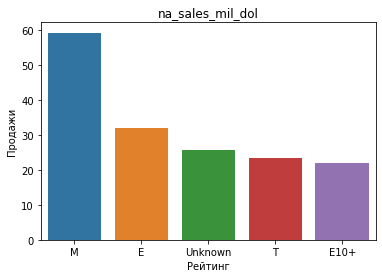

КОЭФФИЦИЕНТЫ КОРРЕЛЯЦИИ
age_rating          1.000000
na_sales_mil_dol    0.081811
Name: age_rating, dtype: float64


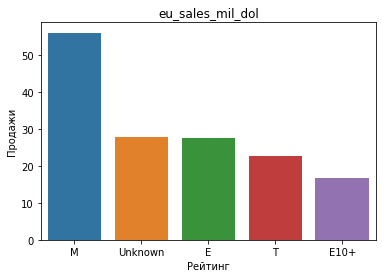

КОЭФФИЦИЕНТЫ КОРРЕЛЯЦИИ
age_rating          1.000000
eu_sales_mil_dol    0.120247
Name: age_rating, dtype: float64


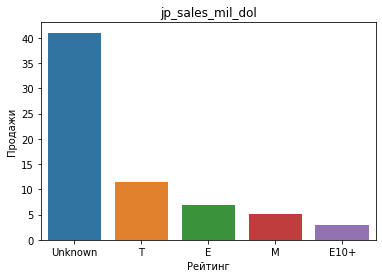

КОЭФФИЦИЕНТЫ КОРРЕЛЯЦИИ
age_rating          1.000000
jp_sales_mil_dol   -0.025339
Name: age_rating, dtype: float64


In [31]:
# Функция которая переводит рейтинг в возраст
def age_rating(row):
    if row == 'E':
        return(6)
    elif row == 'E10+':
        return(10)
    elif row == 'T':
        return(13)
    elif row == 'M':
        return(17)
    else:
        return(0)
# Создаем столбец с возрастом для дальнейшего вычисления коэффициентов корреляции.
df_fresh_b4 = df_fresh_b4.copy()
df_fresh_b4['age_rating'] = df_fresh_b4['rating'].apply(age_rating)

# Создаем диаграммы для каждого региона
for i in range(3):
    # Группируем по рейтингу
    esrb_sales = (df_fresh_b4.pivot_table(index='rating', values=countries[i], aggfunc='sum')
                             .sort_values(countries[i], ascending=False))

    (sns.barplot(data = esrb_sales, x = esrb_sales.index, y = countries[i])
        .set(title = countries[i], xlabel = 'Рейтинг', ylabel = 'Продажи'))
    plt.show()
    # Вычисляем коэффициенты корреляции, убирая при этом нулевые значения
    print('КОЭФФИЦИЕНТЫ КОРРЕЛЯЦИИ')
    print(df_fresh_b4[df_fresh_b4['age_rating'] != 0][['age_rating', countries[i]]].corr()['age_rating'])

In [32]:
df_fresh_b4[df_fresh_b4['rating'] == 'Unknown'].sort_values(by='jp_sales_mil_dol', ascending=False).head(15)

,name,platform,year_of_release,genre,na_sales_mil_dol,eu_sales_mil_dol,jp_sales_mil_dol,other_sales,critic_score,user_score,rating,total_sales_mil_dol,age_rating
506,Yokai Watch 2 Ganso/Honke,3DS,2014,Role-Playing,0.09,0.00,3.18,0.01,NaN,NaN,Unknown,3.28,0
498,Monster Hunter X,3DS,2015,Action,0.27,0.21,2.79,0.05,NaN,NaN,Unknown,3.32,0
699,Yokai Watch 2 Shinuchi,3DS,2014,Role-Playing,0.00,0.00,2.68,0.00,NaN,NaN,Unknown,2.68,0
842,Yokai Watch Busters,3DS,2015,Action,0.00,0.00,2.29,0.00,NaN,NaN,Unknown,2.29,0
1759,Yokai Watch 3,3DS,2016,Action,0.00,0.00,1.33,0.00,NaN,NaN,Unknown,1.33,0
1080,Minecraft,PSV,2014,Misc,0.18,0.64,0.90,0.24,NaN,NaN,Unknown,1.96,0
2804,Monster Strike 3DS,3DS,2015,Action,0.00,0.00,0.87,0.00,NaN,NaN,Unknown,0.87,0
3042,Dragon Quest Monsters 2,3DS,2014,Role-Playing,0.00,0.00,0.79,0.00,NaN,NaN,Unknown,0.79,0
3209,Rhythm Heaven: The Best+,3DS,2015,Misc,0.00,0.03,0.72,0.00,NaN,NaN,Unknown,0.75,0
3694,Dragon Quest Monsters Joker 3,3DS,2016,Role-Playing,0.00,0.00,0.63,0.00,NaN,NaN,Unknown,0.63,0



- По Америке и Европе схожая ситуация наиболее популярным является рейтинг M(17+), потом следует E(6+), затем T(13+) и E10(10+) 
- Самые прибыльные игры в Японии представлены платформой 3DS, которая популярна там же, а организация ESRB - американская. Возможно в Японии есть своя организация, которая присваивает играм возростной рейтинг, поэтому этих данных нет в датафрейме и поэтому рейтинг Unknow имеет лидирующие позиции.


**Вывод:** В результате анализа мы видим, что коэффициенты корреляций относительно невысокие, четкой зависимости продаж от рейтинга не наблюдается.

## Проверяем гипотезы

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
**H0**: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

**H1**: Средние пользовательские рейтинги платформ Xbox One и PC различаются.

In [33]:
sample_1 = df_fresh_b4[df_fresh_b4['platform'] == 'XOne']['user_score'].dropna()
sample_2 = df_fresh_b4[df_fresh_b4['platform'] == 'PC']['user_score'].dropna()
results = st.ttest_ind(sample_1, sample_2)
alpha = 0.05

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Принимаем альтернативную гипотезу')
else:
    print('Опровергнуть нулевую гипотезу нельзя')

p-значение:  0.10445889699999576
Опровергнуть нулевую гипотезу нельзя


### Средние пользовательские рейтинги жанров Action и Sports разные
**H0**: Средние пользовательские рейтинги жанров Action и Sports одинаковые.

**H1**: Средние пользовательские рейтинги жанров Action и Sports различаются.

In [34]:
sample_1 = df_fresh_b4[df_fresh_b4['genre'] == 'Action']['user_score'].dropna()
sample_2 = df_fresh_b4[df_fresh_b4['genre'] == 'Sports']['user_score'].dropna()
results = st.ttest_ind(sample_1, sample_2)
alpha = 0.05

print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Принимаем альтернативную гипотезу')
else:
    print('Опровергнуть нулевую гипотезу нельзя')

p-значение:  9.355290037745116e-10
Принимаем альтернативную гипотезу


## Общий вывод

1. **Актуальные платформы:**
   - На данный момент наиболее актуальными являются платформы PS4 и XOne
   - Платформы 3DS, WiiU теряют свою актуальность, но заслуживают внимания.
   - Платформа PC всегда должна рассматриваться не в отрыве от других платформ:
     на момент 2016г PS4 и XOne находятся на стадии Активных продаж, поэтому ожидать пиковых значений от PC не стоит


2. **Продажи в некоторой степени зависят от оценок критиков (коэф.корреляции примерно 0.4), и не зависят от оценок пользователей**


3. **Актуальные жанры:**
   - Наибольшую прибыльность показали жанры: Shooter, Sports, Role-Playing
   - Наибольшее количество игр в жанрах: Action, Adventure, Role-Playing


4. **Портрет пользователя:**
   
   ***Северная америка:***
   - Основные консоли -- PS4(41%) и XOne (39%)
   - Популярные жанры -- Action(30%) , Shooter(28%) , Sports(17%) , Role-plaing(11%)
   
   ***Европа:***
   - Основные консоли -- PS4(52%), XOne (24%) и PC(11%)
   - Популярные жанры -- Action(33%) , Shooter(20%) , Sports(10%) , Role-plaing(11%)
   
   ***Япония:***
   - Основные консоли -- 3DS(53%), PS4 (19%) и PSV(21%)
   - Популярные жанры -- Action(36%) , Misc(8%), Role-plaing(34%)


5. **Четкой зависимости продаж от возрастного рейтинга не наблюдается**


6. **Гипотезы:**
   - Средние пользовательские рейтинги жанров Action и Sports различаются.
   - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
   
